# Depth Estimation and Segmentation

## Setup the libraries

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

## Helper Functions

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

### Image One

<IPython.core.display.Javascript object>

Saved to photo.jpg


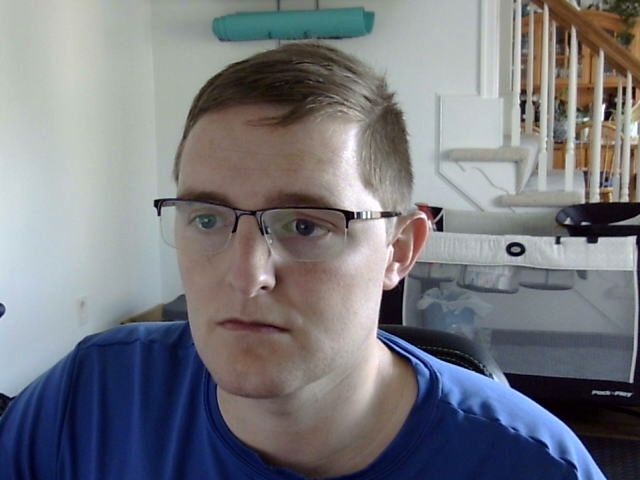

In [8]:
from IPython.display import Image
try:
  filename = take_photo("photo.jpg")
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Image Two

<IPython.core.display.Javascript object>

Saved to photo1.jpg


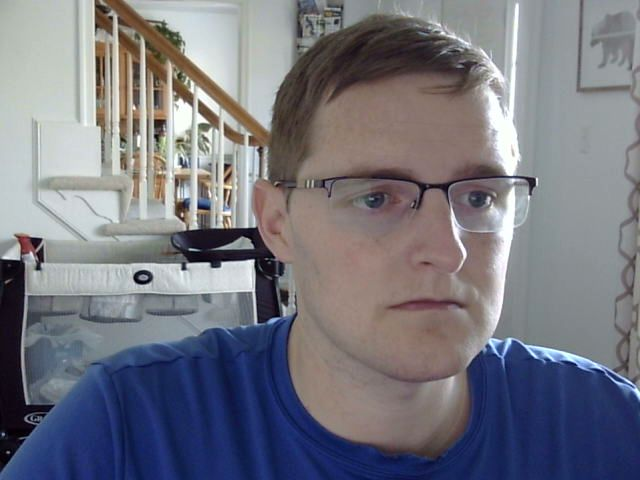

In [6]:
from IPython.display import Image
try:
  filename = take_photo("photo1.jpg")
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Depth Estimation with normal camera

### Stereo Vision

Two cameras simultaneously

In [96]:
# Load the Images
imgR = cv2.imread("photo.jpg")
imgL = cv2.imread("photo1.jpg")

# Grayscale the images
gray_imageR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
gray_imageL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)

In [74]:
# Setup initial values
minDisparity = 2 # Normally 0
numDisparities = 192 - minDisparity # Maximum disparity - minimum disparity
blockSize = 5 # should normally be between 3-11
uniquenessRatio = 1 # 
speckleWindowSize = 3 #
speckleRange = 3 #
disp12MaxDiff = 200 #
P1 = 600 #
P2 = 2400 #

In [116]:
# Create Sterio Instance
stereo = cv2.StereoSGBM_create(
    minDisparity = minDisparity,
    numDisparities = numDisparities,
    blockSize = blockSize,
    uniquenessRatio = uniquenessRatio,
    speckleRange = speckleRange,
    speckleWindowSize = speckleWindowSize,
    disp12MaxDiff = disp12MaxDiff,
    P1 = P1,
    P2 = P2
)

In [117]:
disparity = stereo.compute(gray_imageL, gray_imageR).astype(np.float32) / 16.0
print(disparity)

[[  1.       1.       1.     ... 124.875  124.875  124.8125]
 [  1.       1.       1.     ... 124.9375 124.875  124.8125]
 [  1.       1.       1.     ... 124.9375 124.875  124.875 ]
 ...
 [  1.       1.       1.     ... 107.75   107.75     1.    ]
 [  1.       1.       1.     ... 123.     123.       1.    ]
 [  1.       1.       1.     ... 123.25   123.       1.    ]]


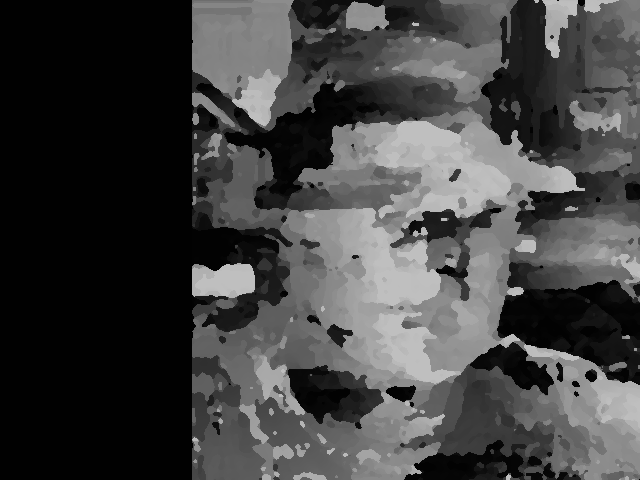

In [118]:
# Filter out noise in the disparity map
disparity = cv2.medianBlur(disparity, ksize=5)
cv2_imshow(disparity)

### Structure from Motion

One camera but move it over time to obtain different perspectives

## Watershed Algorithm

Image segmentation method that works by treating the image as a topographical surface and finding its catchment basins.

The basic idea of the watershed algorithm is to treat the image as a topographical surface, where the intensity values of the pixels can be considered as elevations. The algorithm starts by finding the local minima in the image and using them as seeds for the catchment basins. The catchment basins are then constructed by growing the basins from the seeds and merging them whenever they meet.

The growing of the basins is done by flooding the image from the seeds. The flooding is done by assigning a label to each seed and then assigning the same label to the neighboring pixels with a higher elevation than the current pixel. This process is repeated until the basins reach the local maxima, which are considered as the watershed lines.

Once the catchment basins are constructed, the watershed lines are used to separate the objects in the image. The final segmented image is obtained by replacing the catchment basin labels with a color for each object.

The watershed algorithm is a tool for image segmentation, but it can also produce over-segmented results if the image has a lot of noise or if the seeds are not chosen correctly. To overcome this, pre-processing steps such as morphological operations, thresholding, and filtering can be applied to the image to improve the results.

In [135]:
!wget https://raw.githubusercontent.com/PacktPublishing/Learning-OpenCV-4-Computer-Vision-with-Python-Third-Edition/master/images/5_of_diamonds.png

--2023-02-07 15:06:50--  https://raw.githubusercontent.com/PacktPublishing/Learning-OpenCV-4-Computer-Vision-with-Python-Third-Edition/master/images/5_of_diamonds.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11539 (11K) [image/png]
Saving to: ‘5_of_diamonds.png’

5_of_diamonds.png   100%[===================>]  11.27K  --.-KB/s    in 0s      

2023-02-07 15:06:51 (72.8 MB/s) - ‘5_of_diamonds.png’ saved [11539/11539]



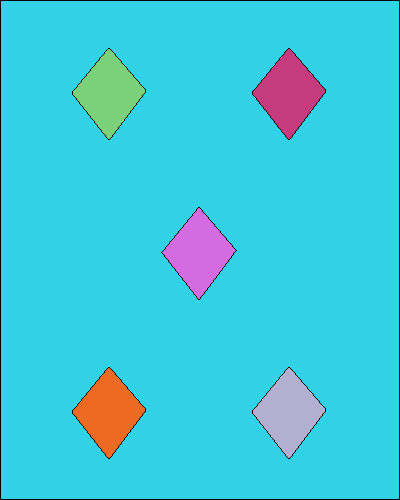

In [136]:
# Load the Images
img = cv2.imread("5_of_diamonds.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blurring to reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Otsu's Thresholding
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform morphological operations to remove small objects
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Perform watershed segmentation
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labesl so that sure background is not 0, but 1
markers = markers + 1

# label unknown regions as 0
markers[unknown == 255] = 0
markers = cv2.watershed(img, markers)

# Generate a random color for each segment
colors = []
for i in range(ret):
    colors.append((np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)))

# Paint the segments with different colors
segmented = np.zeros_like(img)
for i in range(ret):
    segmented[markers == i + 1] = colors[i]

cv2_imshow(segmented)

## GrabCut Algorithm (Foreground/Background)

iterative algorithm for foreground/background segmentation in an image. It is an improved version of the traditional watershed algorithm, which gives more accurate results in terms of separating the foreground and background regions.

The algorithm works in five steps:

* Initialization: The user provides an initial rough mask that indicates the foreground and background regions in the image. The mask can be a simple rectangle around the object of interest or a more complex shape.

* Markov Random Field Model (MRF): The MRF model is used to model the relationships between the foreground and background pixels based on their color and texture features. The MRF model is used to compute the probability of each pixel belonging to the foreground or the background.

* Graph Cut Optimization: The MRF model is then optimized using the Graph Cut algorithm to find the optimal foreground/background segmentation. The optimization is done by computing the maximum a posteriori (MAP) estimate of the probabilities of each pixel.

* Refinement: The resulting segmentation is refined by updating the MRF model with the newly computed probabilities and repeating the optimization step. The iteration continues until the model converges to a stable solution.

* Output: The final output of the algorithm is the binary mask that separates the foreground and background regions in the image.

The GrabCut algorithm is a foreground/background segmentation in images, and it is widely used in computer vision and image processing applications. The algorithm requires a rough initial mask and a few iterations to converge to a stable solution, but it provides more accurate results compared to traditional watershed-based algorithms.

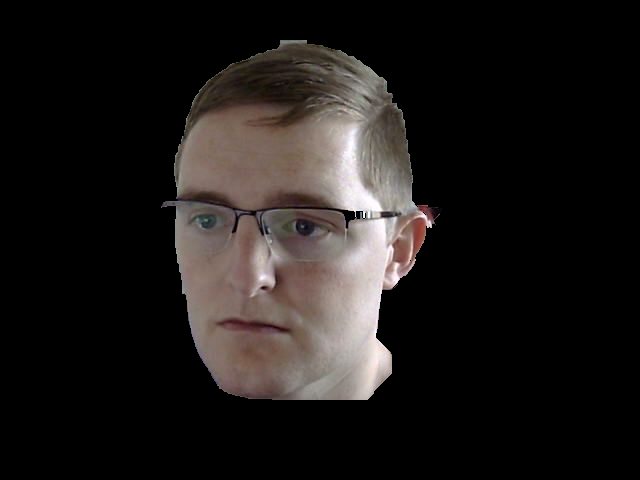

In [127]:
# Load the Images
img = cv2.imread("photo.jpg")

# Grayscale the images
gray_image = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define the initial rectangle for the object to be segmented
rect = (25, 25, 450, 375)

cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create the final mask by marking the sure foreground and background pixels
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
img = img * mask2[:, :, np.newaxis]

cv2_imshow(img)